In [74]:
import numpy as np
import numpy as np
import pandas as  pd
import tensorflow as tf
from tensorflow import keras
#import keras
import matplotlib.pyplot as plt 
from tensorflow.keras import layers
from sklearn import *
import math
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import scipy
tf.autograph.set_verbosity(0)
from ipynb.fs.defs.UtilitiesVED import *
plt.rcParams["figure.figsize"] = (20,10)


## Import Data


In [6]:
X = pd.read_csv("../../Data/data_90TTI/X_90_TTI_arg.csv", index_col=0)
y = pd.read_csv("../Data/data_90TTI/y_90_TTI_arg.csv", index_col=0)



In [7]:
print(X.shape)
print(y.shape)

(90, 618)
(90, 1854)


In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, shuffle=False)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(54, 618)
(54, 1854)
(36, 618)
(36, 1854)


In [10]:
#X = tf.stack(X)
#y = tf.stack(y)

In [11]:
#X_train = tf.stack(X_train)
#X_test = tf.stack(X_test)
#y_train = tf.stack(y_train)
#y_test = tf.stack(y_test)

In [12]:
X_train = (X_train.to_numpy())
X_test = (X_test.to_numpy())
y_train = (y_train.to_numpy())
y_test = (y_test.to_numpy())

In [13]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_esc = scaler.transform(X_train)
X_test_esc = scaler.transform(X_test)


## Create a sampling layer


## Build the encoder


In [15]:
latent_dim = 100 # Latent Space dimension on the bottleneck
input_dim = X_train.shape[1]
ReLu = keras.layers.ReLU()

encoder_inputs = keras.Input(shape=( input_dim, ))
x = layers.Dense(309, activation=ReLu)(encoder_inputs)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 618)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 309)          191271      ['input_2[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 100)          31000       ['dense_1[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 100)          31000       ['dense_1[0][0]']                
                                                                                            

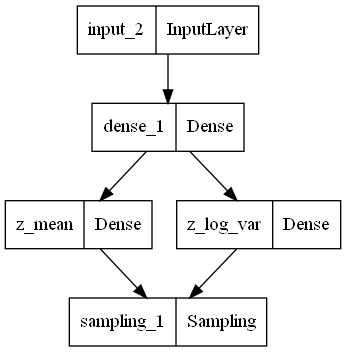

In [16]:
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(encoder, to_file='encoder.png')

## Build the decoder


In [17]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(50,  activation=ReLu)(latent_inputs)
decoder_outputs = layers.Dense(618 * 3, activation="linear")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1854)              94554     
                                                                 
Total params: 99,604
Trainable params: 99,604
Non-trainable params: 0
_________________________________________________________________


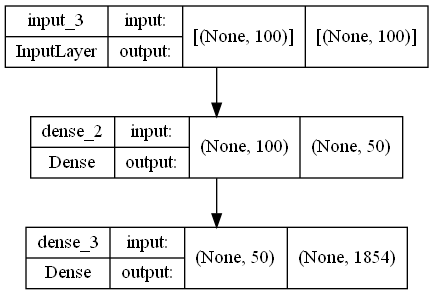

In [18]:
plot_model(decoder,  show_shapes=True, show_layer_names=True)

## Define the VAE as a Model with a custom train_step


## Train the VAE

In [19]:
vae = VAE(encoder, decoder, 1)

In [20]:
vae.compile(optimizer=keras.optimizers.Adam())

In [21]:
es = keras.callbacks.EarlyStopping(
    monitor="MSE",
    patience=4,
)

In [22]:
history = vae.fit(X_train_esc, y_train, validation_data=(X_test_esc , y_test), epochs=15, batch_size=1 )

Epoch 1/15
54/54 [==============================] - 2s 13ms/step - loss: 66.2035 - MSE: 1.7166 - kl_loss: 57.9404 - val_loss_val: 61.6444 - val_MSE_val: 1.6912 - val_kl_loss_val: 59.9532
Epoch 2/15
54/54 [==============================] - 0s 7ms/step - loss: 34.3329 - MSE: 1.6684 - kl_loss: 27.9371 - val_loss_val: 51.8825 - val_MSE_val: 1.6940 - val_kl_loss_val: 50.1885
Epoch 3/15
54/54 [==============================] - 0s 7ms/step - loss: 20.2096 - MSE: 1.6564 - kl_loss: 14.7834 - val_loss_val: 47.7770 - val_MSE_val: 1.7021 - val_kl_loss_val: 46.0749
Epoch 4/15
54/54 [==============================] - 0s 9ms/step - loss: 11.3569 - MSE: 1.6496 - kl_loss: 11.0991 - val_loss_val: 46.2126 - val_MSE_val: 1.7032 - val_kl_loss_val: 44.5094
Epoch 5/15
54/54 [==============================] - 1s 10ms/step - loss: 12.7099 - MSE: 1.6533 - kl_loss: 11.6185 - val_loss_val: 47.9579 - val_MSE_val: 1.6982 - val_kl_loss_val: 46.2597
Epoch 6/15
54/54 [==============================] - 0s 7ms/step - lo

In [24]:
def nrmse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    den = tf.math.reduce_sum(tf.square(y_test))/y_test.shape[1]
    
    return (num/den).numpy()

def mse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

def mae(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.abs(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

print('NRMSE', nrmse(vae.predict(X_test), y_test))
print('MAE', mae(vae.predict(X_test), y_test))
print('RMSE', math.sqrt(mse(vae.predict(X_test), y_test)))
print('MSE', mse(vae.predict(X_test), y_test))


NRMSE 1.0356338219301717
MAE 29.51596251971289
RMSE 7.844974968069025
MSE 61.939196611634024


# PLOTS


In [25]:
samp_num = 1

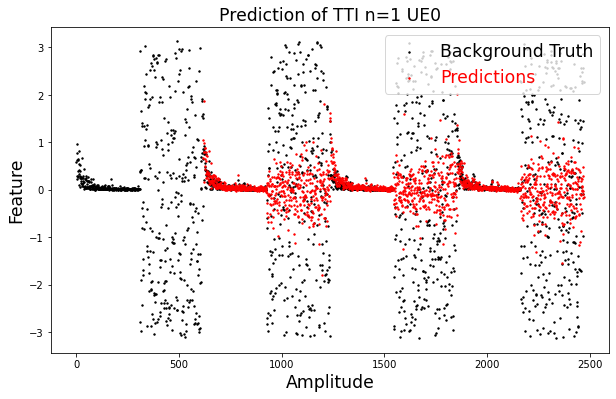

In [26]:
plt_1 = plt.figure(figsize=(10, 6))
sample_1 = np.r_[ y_test[samp_num,], X_test[samp_num,]]
idx = np.arange(len(sample_1))
plt.scatter(np.arange(len(sample_1)), sample_1, s=2, c="black")
plt.scatter(idx[-len(vae.predict(X_test)[samp_num,]):], vae.predict(X_test)[samp_num,], color='red',  s=2)
plt.title('Prediction of TTI n={} UE0'.format(samp_num) , fontsize ='xx-large')
plt.legend(['Background Truth', 'Predictions'],labelcolor = ['black', 'red'] ,loc='upper right', fontsize ='xx-large')
plt.ylabel('Feature', fontsize ='xx-large')
plt.xlabel('Amplitude', fontsize ='xx-large')

plt.show()

In [27]:
print(history.history.keys())

dict_keys(['loss', 'MSE', 'kl_loss', 'val_loss_val', 'val_MSE_val', 'val_kl_loss_val'])


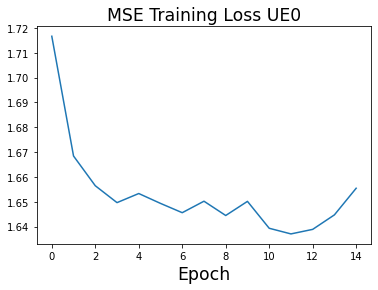

In [28]:
plt.plot(history.history['MSE'])
plt.title('MSE Training Loss UE0', fontsize ='xx-large')
plt.xlabel('Epoch', fontsize ='xx-large')
plt.show()

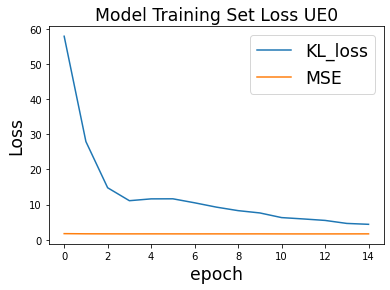

In [29]:
plt.plot(history.history['kl_loss'])
#plt.plot(history.history['val_total_loss'])
plt.title('Model Training Set Loss UE0', fontsize ='xx-large')
plt.ylabel('Loss', fontsize ='xx-large')
plt.xlabel('epoch', fontsize ='xx-large')
plt.plot(history.history['MSE'])
plt.legend(['KL_loss', 'MSE'], loc='upper right', fontsize ='xx-large')
plt.show()


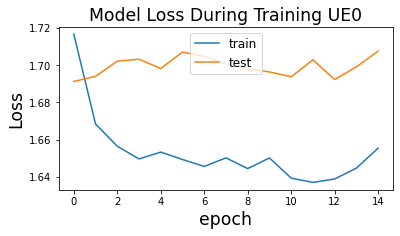

In [30]:
# summarize history for accuracy
plt_1 = plt.figure(figsize=(6, 3))

plt.plot(history.history['MSE'])
#plt.plot(history.history['val_total_loss'])
plt.ylabel('Loss', fontsize ='xx-large')
plt.xlabel('epoch', fontsize ='xx-large')
plt.plot(history.history['val_MSE_val'])

plt.legend(['train', 'test'], loc='upper center', fontsize ='12')
plt.title('Model Loss During Training UE0', fontsize='xx-large')

plt.show()


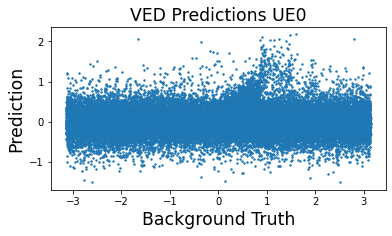

In [31]:
plt_1 = plt.figure(figsize=(6, 3))
plt.scatter(y_test.flatten(), vae.predict(X_test_esc).flatten(), s=2)
plt.title('VED Predictions UE0', fontsize='xx-large')
plt.ylabel('Prediction', fontsize ='xx-large')
plt.xlabel('Background Truth', fontsize ='xx-large')

plt.show()

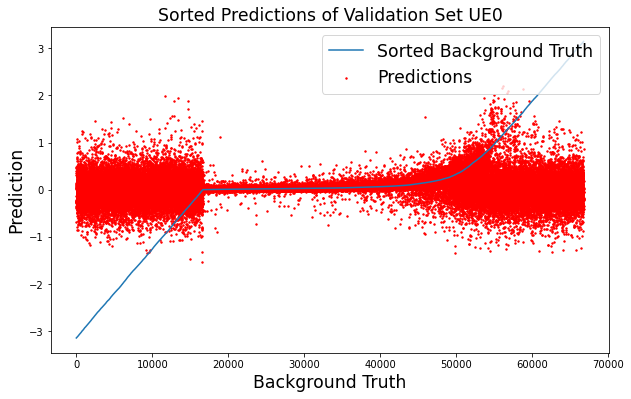

In [32]:
plt_1 = plt.figure(figsize=(10, 6))

plt.plot(np.sort(y_test.flatten()))
x_idx = np.arange(len(y_test.flatten()))
plt.scatter(x_idx, vae.predict(X_test_esc).flatten()[np.argsort(y_test.flatten())], s=2, c="red")

plt.title('Sorted Predictions of Validation Set UE0', fontsize='xx-large')
plt.ylabel('Prediction', fontsize ='xx-large')
plt.xlabel('Background Truth', fontsize ='xx-large')
plt.legend(['Sorted Background Truth', 'Predictions'], loc='upper right', fontsize ='xx-large')

plt.show()


# 

# Modeling

In [33]:
import scipy

In [36]:
mpc = 309
name_ds = 'UE0 polar'

In [37]:
y_pred = vae.predict(X_test)

y_pred.shape


(36, 1854)

<Figure size 720x432 with 0 Axes>

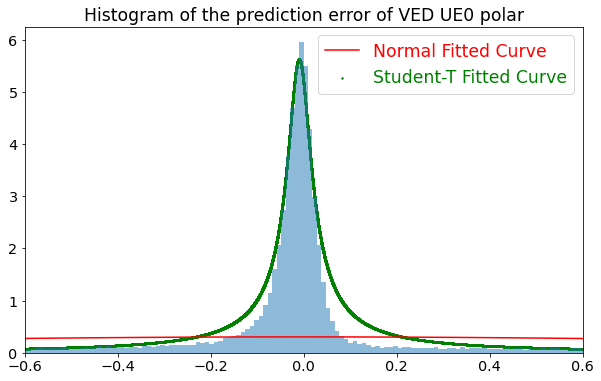

In [38]:
plt_1 = plt.figure(figsize=(10, 6))

# Error to be fitted
data = y_test.flatten() - vae.predict(X_test_esc).flatten()
plot_modeling_prediction_error(data, y_test, y_pred, name_ds, nbins=1000)

# Reconstruct the validation set

In [75]:
data = pd.read_csv("../../Data/data_90TTI/data_unfold.csv", index_col=0).values

In [76]:
from matplotlib.pyplot import *


In [77]:
data.shape

(90, 2472)

# Reconstruct the validation set

In [79]:
y_pred = vae.predict(X_test_esc)


In [80]:
reconstruct_valid = reconstruct_validation(mpc, y_pred, X_test)


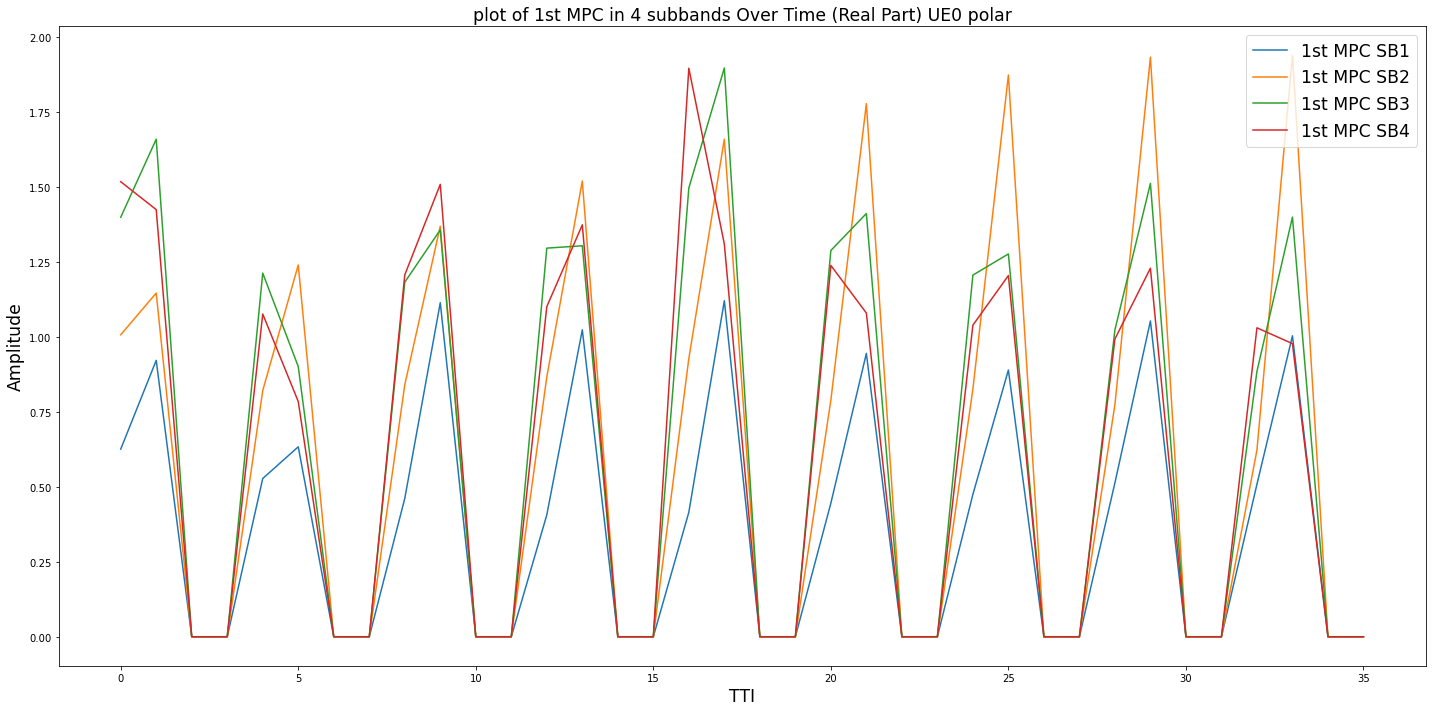

In [93]:
plot_MPC_overtime(reconstruct_valid, mpc, name_ds, True)

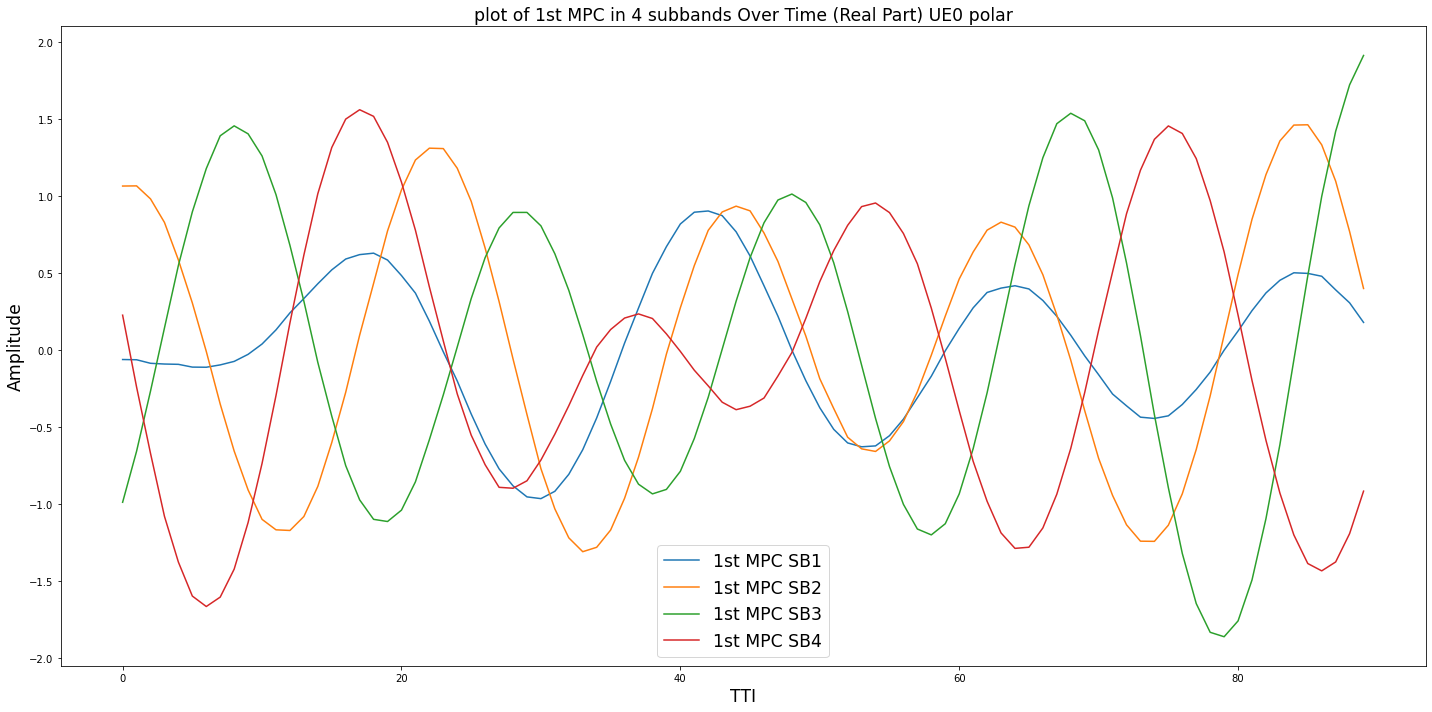

In [90]:
plot_MPC_overtime(data, mpc, name_ds, True)